In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof

In [2]:
print(tf.__version__)

2.5.0


# Helper Functions

In [3]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [4]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>


In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

In [7]:
train_images.shape

(60000, 28, 28)

In [8]:
len(train_labels)

60000

In [9]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# Test Dataset

In [10]:
test_images.shape

(10000, 28, 28)

In [11]:
len(test_labels)

10000

## Preprocessing

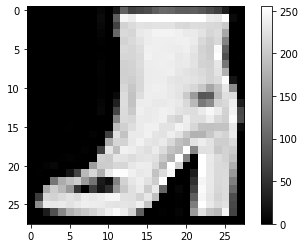

In [12]:
plt.figure()
plt.imshow(train_images[88], cmap="gray")
plt.colorbar()
plt.grid(False)
plt.show()

In [13]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## Build & Compile the model


In [14]:
model = keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10)
])

In [15]:
model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 6s 2ms/step - loss: 0.4961 - accuracy: 0.8246
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3709 - accuracy: 0.8660
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3330 - accuracy: 0.8788
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3087 - accuracy: 0.8861
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2920 - accuracy: 0.8923
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2770 - accuracy: 0.8978
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2648 - accuracy: 0.9016
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2556 - accuracy: 0.9043
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2450 - accuracy: 0.9091
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.236

In [17]:
KERAS_MODEL_NAME = "tf_model_fashion_mnist.h5"

In [18]:
model.save(KERAS_MODEL_NAME)

In [19]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.19 Megabytes


In [20]:
keras_model_size = get_file_size(KERAS_MODEL_NAME)

In [21]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

313/313 - 1s - loss: 0.3242 - accuracy: 0.8867

Test accuracy is 88.67%


# TF Lite Model

In [22]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [23]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpqqy3prkz/assets


In [24]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

408544

In [25]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 398.969 Kilobytes


In [26]:
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

# Check Input Tensor Shape

In [27]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


# Resize Tensor Shape

In [28]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [29]:
test_images.dtype

dtype('float64')

In [30]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [31]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [32]:
acc = accuracy_score(prediction_classes, test_labels)

In [33]:
print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE model is 88.67%


In [34]:
tflite_file_size/keras_model_size

0.327442934085663

# TF Lite Model Float 16

In [35]:
TF_LITE_MODEL_FLOAT_16_FILE_NAME = "tf_lite_float_16_model.tflite"

In [36]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpt6l796cp/assets


INFO:tensorflow:Assets written to: /tmp/tmpt6l796cp/assets


In [37]:
tflite_model_name = TF_LITE_MODEL_FLOAT_16_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

205632

In [38]:
convert_bytes(get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME), "KB")

File size: 200.812 Kilobytes


In [39]:
tflite_float_16_file_size = get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME)

In [40]:
tflite_float_16_file_size/keras_model_size

0.16481149012567325

In [41]:
tflite_float_16_file_size/tflite_file_size

0.5033288948069241

# TF Lite Size Quantized

In [42]:
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"

In [43]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpd1p8vjt5/assets


INFO:tensorflow:Assets written to: /tmp/tmpd1p8vjt5/assets


In [44]:
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

103856

In [45]:
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 101.422 Kilobytes


In [46]:
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)

In [47]:
tflite_float_quant_file_size/keras_model_size

0.0832392921261862

In [48]:
tflite_float_quant_file_size/ tflite_float_16_file_size

0.5050575785869903

# Accuracy of the Quantized Model

# Check Input Tensor Shape

In [49]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


# Resize Tensor Shape

In [50]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [51]:
test_images.dtype

dtype('float64')

In [52]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [53]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [54]:
acc = accuracy_score(prediction_classes, test_labels)

In [55]:
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 88.57%


# Get Weights of Keras Model

In [56]:
print(model.get_weights()[0][0][0], type(model.get_weights()[0][0][0]))

-0.06525691 <class 'numpy.float32'>


In [57]:
model.get_weights()[0][0][0].__sizeof__()

28

# Access Quantized Weights of TFLite

In [60]:
TF_LITE_WEIGHTS_TEMP_FILE = "temp_weights_from_tflite.h5"

In [61]:
interpreter = tf.lite.Interpreter(model_path=TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
all_layers_details = interpreter.get_tensor_details() 
f = h5py.File(TF_LITE_WEIGHTS_TEMP_FILE, "w")   
for layer in all_layers_details:
     grp = f.create_group(str(layer['index']))
     grp.attrs["name"] = layer['name']
     grp.attrs["shape"] = layer['shape']
     grp.attrs["quantization"] = layer['quantization']
     grp.create_dataset("weights", data=interpreter.get_tensor(layer['index']))
f.close()

In [62]:
temp_file = h5py.File(TF_LITE_WEIGHTS_TEMP_FILE, 'r')
print(temp_file["5"]["weights"][0][6], type(temp_file["5"]["weights"][0][6]))

13 <class 'numpy.int8'>


In [63]:
temp_file["5"]["weights"][0][6].__sizeof__()

25

In [64]:
temp_file.close()